Multicollinearity exists whenever an independent variable is highly correlated with one or more of the other independent variables in a multiple regression equation. Multicollinearity is a problem because it undermines the statistical significance of an independent variable, reduces the precision of the estimated coefficients, and it affects the interpretability. In this notebook, p-value for coefficients of regression and Variance Inflation Factor is applied to detect and remove multicollinearity. Realistic and synthetic examples are presented.

Python functions and data files to run this notebook are in my [Github](https://github.com/MehdiRezvandehy/Feature_Importance.git) page.

In [1]:
import matplotlib.pyplot as plt
from IPython.display import Image
from pandas import DataFrame
from sklearn import linear_model
import statsmodels.api as sm
from functions import* # import require functions to run this notebook
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import random
import math
import warnings
warnings.filterwarnings('ignore')

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Energy-Efficiency-Dataset" data-toc-modified-id="Energy-Efficiency-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Energy Efficiency Dataset</a></span></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Logistic Regression</a></span><ul class="toc-item"><li><span><a href="#Lasso-Logistic-Regression" data-toc-modified-id="Lasso-Logistic-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Lasso Logistic Regression</a></span></li></ul></li><li><span><a href="#Variance-Inflation-Factor" data-toc-modified-id="Variance-Inflation-Factor-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Variance Inflation Factor</a></span></li><li><span><a href="#Synthetic-Example-1" data-toc-modified-id="Synthetic-Example-1-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Synthetic Example 1</a></span></li><li><span><a href="#Synthetic-Example-2" data-toc-modified-id="Synthetic-Example-2-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Synthetic Example 2</a></span></li></ul></div>

# Introduction

Multicollinearity is a condition where a predictor variable (independent variable) correlates with another predictor. For example, if there is high correlation between 22 selected features. Although multicollinearity may not affect the model’s performance, it will affect the interpretability especially for linear and logistic regression. If we don’t remove the multicollinearity, we will never know how much a variable contributes to the result. It will be recalled that one of the factors that affects the standard error of a partial regression coefficient in the regression equation is multicollinearity. The standard error represents the average distance that the observed values fall from the regression line. An independent variable that is very highly correlated with one or more other independent variables will have a relatively large standard error. This implies that the partial regression coefficient is unstable and will vary greatly from one sample to the next. It undermines the statistical significance of an independent variable. The larger the standard error of a regression coefficient, the less likely it is that this coefficient will be statistically significant. There are two types of multicollinearity:

**Perfect** multicollinearity obtains whenever one independent variable is a perfect linear function of one or more of the other independent variables in a regression equation. This multicollinearity can be easily detected.

**Extreme** multicollinearity is often more difficult than perfect multicollinearity because it frequently goes undetected. Extreme multicollinearity occurs whenever an independent variable is very highly correlated with one or more other independent variables.


Moderate multicollinearity may not be problematic. However, extreme multicollinearity is a problem because it can increase the variance of the coefficient estimates and make the estimates very sensitive to minor changes in the model. **The result is that the coefficient estimates are unstable and difficult to interpret.**
**Whenever two independent variables are very highly correlated with one another, neither or them is likely to be statistically significant, even though they may both be highly correlated with the dependent variable.**

<span class="mark">Multicollinearity saps the statistical power of the analysis, can cause the coefficients to switch signs, and makes it more difficult to specify the correct model.</span>


Here is an example to explain multicollinearity. The equation below shows coefficient $\beta_{1}$ to $\beta_{4}$ for 4 independent variables 4 (predictors) $X_{1}$ to $X_{4}$ from linear and logistic regression:

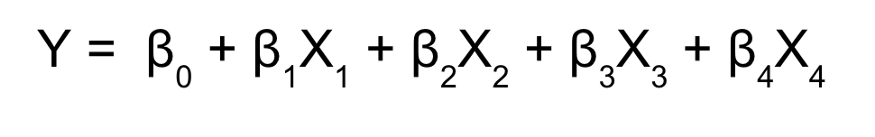

If  variables $X_{1}$ to $X_{4}$ are independent from each other, change the magnitude of feature will not cause any other independent variable to change its value or by some negligible amount. For each, increasing $X_{1}$ will increase Y but have low impact on $X_{2}$ to $X_{4}$ 


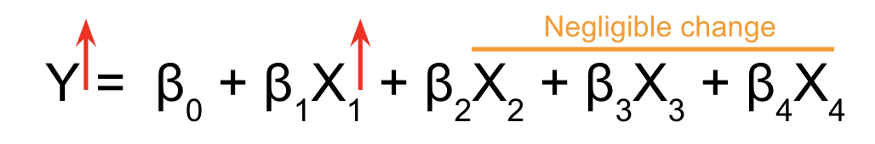

However, in case of high correlation between variables $X_{3}$ and $X_{4}$, we achieve unreliable results. If the magnitude of $X_{3}$ increases (as shown in red) to observe the change in Y(red), there will also be a significant difference in the value of $X_{4}$ (orange). As a result, the change that we observe in Y is due to the change in both $X_{3}$ (red) and $X_{4}$ (orange). The resultant change(blue) is greater than the Actual change (orange).

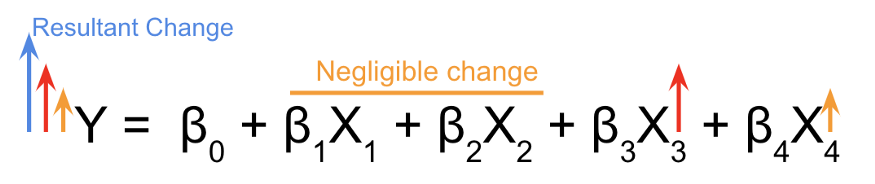


Since we are trying to estimate the coefficient corresponding to $X_{3}$, **the contribution of variable $X_{4}$ causes the coefficient to be unstable (overestimated or underestimated).** Regression algorithm tries to optimize $\beta_{1}$ to $\beta_{4}$ to have the minimum error between prediction and actual. The optimization may give very high value to $\beta_{3}$ (overestimated) and very low value to $\beta_{4}$ (underestimated). This can be easily switched if there is a small change in model or random subset of data. Since $\beta_{3}$ and $\beta_{4}$ will be unstable, this will mislead our interpretations. See [Medium](https://medium.com/analytics-vidhya/what-is-multicollinearity-and-how-to-remove-it-413c419de2f) for more information.

# Energy Efficiency Dataset

You can find different real datasets on the [UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets.php) which are processed and cleaned before and ready to feed Machine Learning algorithms. I found [Energy Efficiency Data Set](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency) useful for this course. Energy analysis are performed for 768 simulated building shapes with respect to 8 features including Wall Area, Overall Height, Glazing Area, Orientation.. to predict Heating Load. The work has been published by Tsanas and Xifara 2012 on [Energy and Buildings Journal](https://www.sciencedirect.com/science/article/pii/S037877881200151X). In this notebook, we will apply multicollinearity analysis for Heating Load (Binary Classes) as the target.

To understand multicollinearity, we can make correlation (covariance) matrix between predictors. See Figure below for correlation matrix between features and target (Heating Load).

In [2]:
df = pd.read_csv('./Data/Building_Heating_Load.csv',na_values=['NA','?',' '])
np.random.seed(32) 
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df=df[['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area',
       'Overall Height', 'Orientation', 'Glazing Area',
       'Glazing Area Distribution', 'Binary Classes']]

df['Binary Classes']=np.where(df['Binary Classes']=='Low Level',0,1)


from scipy.stats import zscore
for icolm in df.drop('Binary Classes', axis=1).columns:
    df[icolm] = zscore(df[icolm])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative Compactness       768 non-null    float64
 1   Surface Area               768 non-null    float64
 2   Wall Area                  768 non-null    float64
 3   Roof Area                  768 non-null    float64
 4   Overall Height             768 non-null    float64
 5   Orientation                768 non-null    float64
 6   Glazing Area               768 non-null    float64
 7   Glazing Area Distribution  768 non-null    float64
 8   Binary Classes             768 non-null    int32  
dtypes: float64(8), int32(1)
memory usage: 51.1 KB


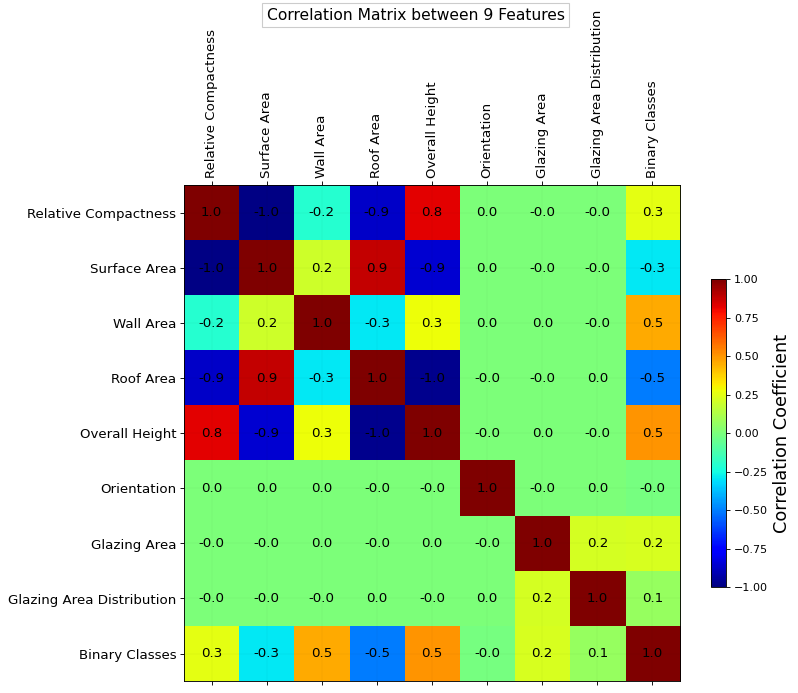

In [3]:
# Correlation matrix
font = {'size'   : 16}
plt.rc('font', **font)
fig, ax=plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')

corr_array=Correlation_plot.corr_mat(df,corr_val_font=12,
        title=f'Correlation Matrix between {len(df.columns)} Features'
         ,titlefontsize=14,xy_title=[1,-3.5],xyfontsize = 12,vlim=[-1, 1],axt=ax)

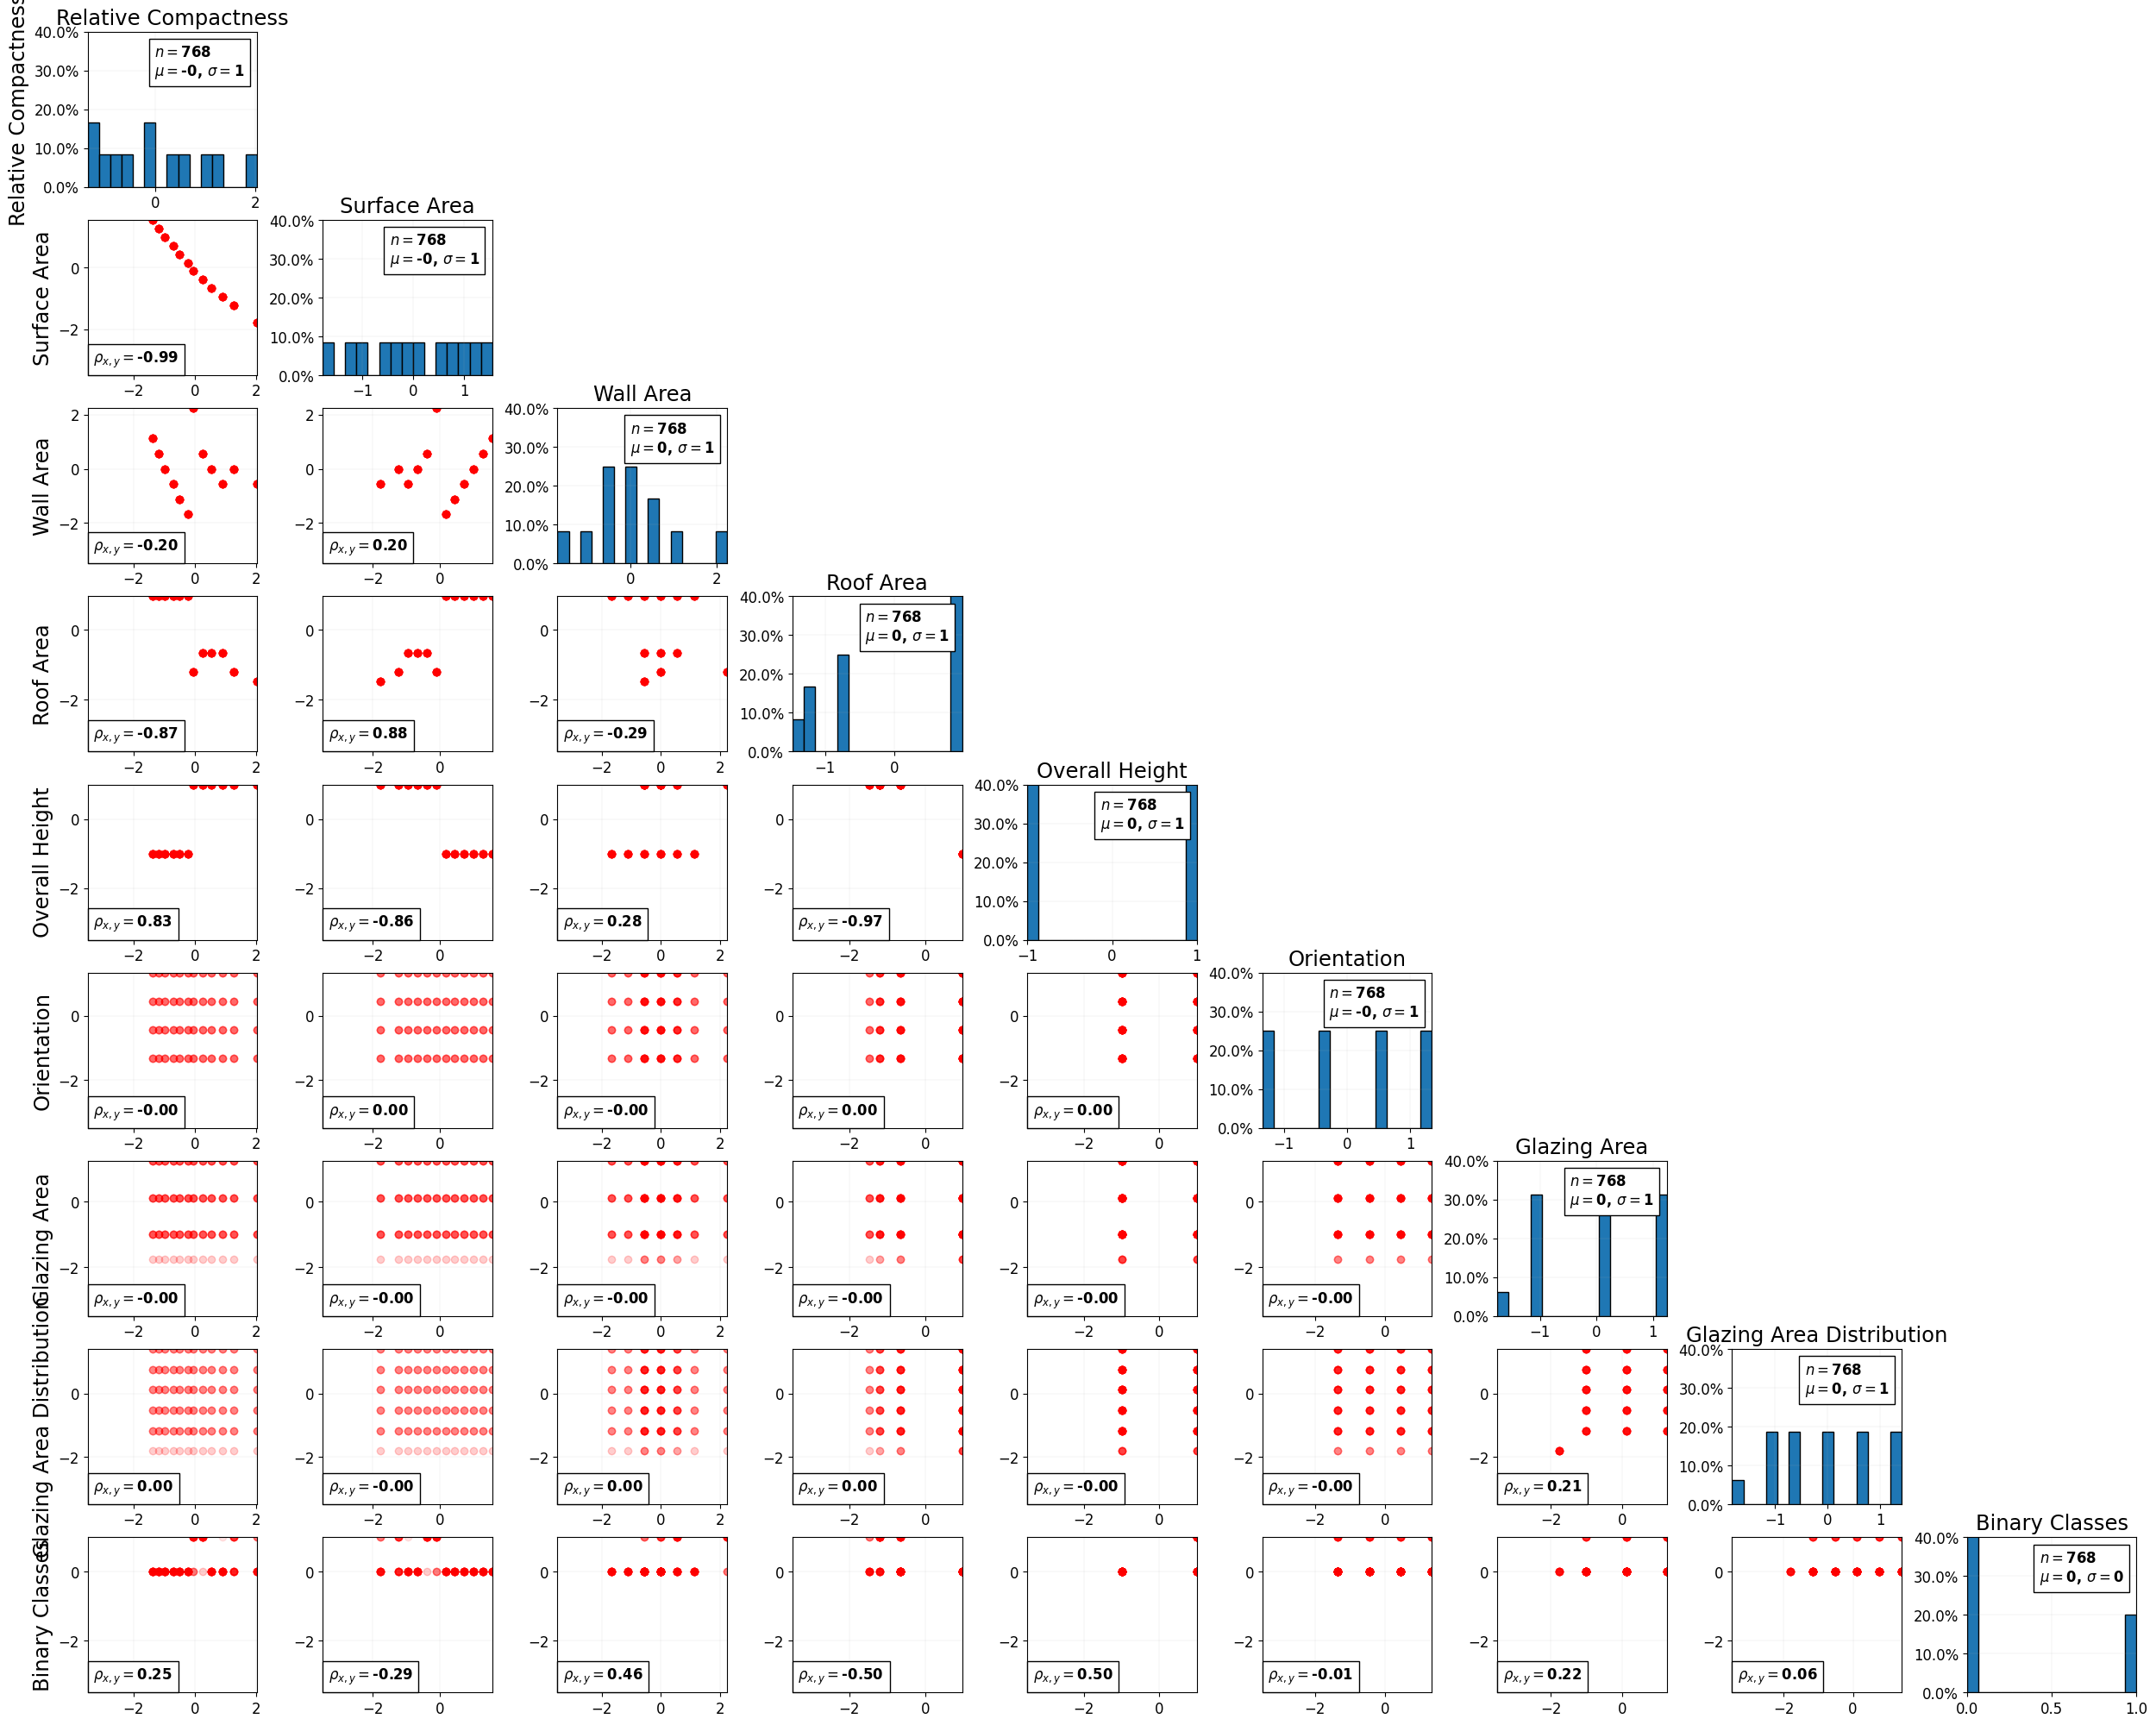

In [4]:
font = {'size'   :14 }
plt.rc('font', **font)

fig=plt.figure(figsize=(25, 20), dpi= 100, facecolor='w', edgecolor='k')
# Make cross plot matrix
cplotmatrix(df,alpha=0.05,marker='ro',missin_rep=False, font=font)

From the correlation matrix above, there are some features that have collinearity. Histogram and CDF of correlations between features can be calculated to quantify percentage of high correlation. Since the correlation matrix is symmetrical, we can get only upper case or lower case matrix and remove correlation 1 on diagonal elements.

In [5]:
input_features=df.drop('Binary Classes', axis=1)

In [6]:
corr_coeff=input_features.corr()
corr_coeff

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution
Relative Compactness,1.000000e+00,-9.919015e-01,-2.037817e-01,-8.688234e-01,8.277473e-01,3.758568e-18,-1.590163e-17,-6.938894e-18
Surface Area,-9.919015e-01,1.000000e+00,1.955016e-01,8.807195e-01,-8.581477e-01,1.590163e-17,-8.095376e-18,-6.649773e-18
Wall Area,-2.037817e-01,1.955016e-01,1.000000e+00,-2.923165e-01,2.809757e-01,1.211731e-17,9.227974e-18,-6.387750e-18
Roof Area,-8.688234e-01,8.807195e-01,-2.923165e-01,1.000000e+00,-9.725122e-01,-2.602085e-18,-2.139492e-17,1.619075e-17
Overall Height,8.277473e-01,-8.581477e-01,2.809757e-01,-9.725122e-01,1.000000e+00,-2.197316e-17,2.573173e-17,-2.602085e-18
Orientation,3.758568e-18,1.590163e-17,1.211731e-17,-2.602085e-18,-2.197316e-17,1.000000e+00,-1.503427e-17,3.093590e-17
Glazing Area,-1.590163e-17,-8.095376e-18,9.227974e-18,-2.139492e-17,2.573173e-17,-1.503427e-17,1.000000e+00,2.129642e-01
Glazing Area Distribution,-6.938894e-18,-6.649773e-18,-6.387750e-18,1.619075e-17,-2.602085e-18,3.093590e-17,2.129642e-01,1.000000e+00


In [7]:
# Get only lower matrix excluding diagonal elelmtes which have correlation 1
corr_coeff=corr_coeff.where(~np.triu(np.ones(corr_coeff.shape)).astype(np.bool))
corr_coeff_=corr_coeff.stack().reset_index()
corr_coeff_.columns  = ['Row','Column','Value']

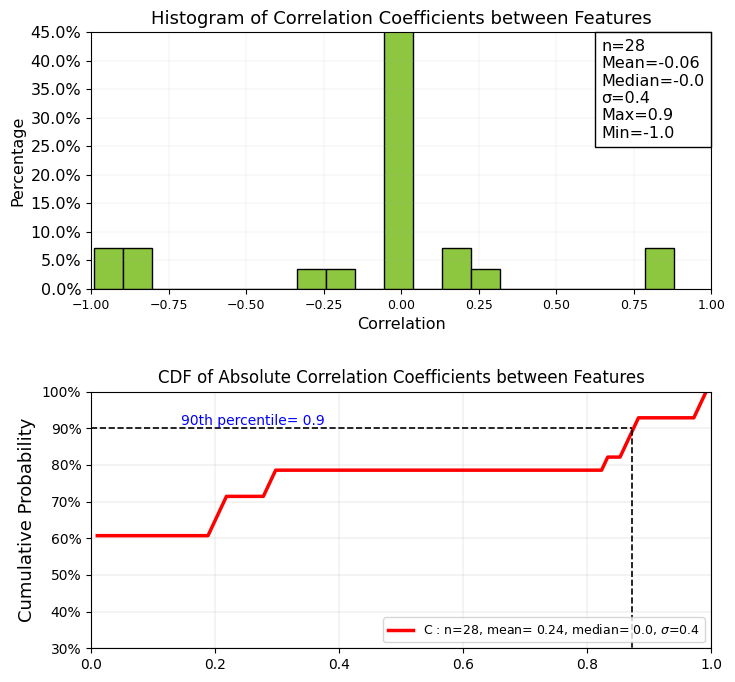

In [8]:
font = {'size'   : 9}
plt.rc('font', **font)
fig, ax1 = plt.subplots(figsize=(8, 8), dpi= 100, facecolor='w', edgecolor='k')

ax1=plt.subplot(2,1,1) 
corr_array=corr_coeff_['Value']
EDA_plot.histplt (np.array(corr_array),bins=20,title='Histogram of Correlation Coefficients between Features',xlabl='Correlation',
         ylabl='Percentage',xlimt=(-1,1),ylimt=(0,0.45),axt=ax1,
         scale=1.15,loc=1,font=10,color='#8DC63F')
ax2=plt.subplot(2,1,2) 
data_var=[None]
data_var[0]=[abs(i) for i in corr_array]
title_cdf=f'CDF of Absolute Correlation Coefficients between Features'
EDA_plot.CDF_plot(data_var,1,label='Correlation',colors='r',xlabel=None,title=title_cdf,
    ylabel='Cumulative Probability',bins=100,xlim=(0,1),ylim=(00.3,1),linewidth=2.5,loc=4,
    axt=ax2,x_ftze=12,y_ftze=13,tit_ftze=12,leg_ftze=9)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# 90th percentile
per=0.9
Perctile=np.quantile(data_var[0], per, axis=0, keepdims=True)[0]
txt= '90th percentile= '
txt+=f'{np.round(Perctile,1)}'
plt.plot([0, Perctile], [per, per], 'k--', linewidth=1.2)
plt.plot([Perctile, Perctile], [0, per], 'k--', linewidth=1.2)
plt.text(Perctile/6, per+0.01, txt, color='b',
         fontsize=10)

plt.subplots_adjust(hspace=0.4)

CDF (bottom Figure) shows 10% of features have correlation more than 0.9. Probably those features that have correlation bigger than 0.9 should be removed from data set. However, this is a native approach; more investigation should be done to find and remove multicollinearity.

# Logistic Regression

`sklearn.linear_model.LogisticRegression`  do not calculate the p-value and uncertainty interval for each coefficient. `statsmodels` automatically calculates standard error, z values, p-values, p2.5% and p97.5% for each coefficient. Those features with high p-values may be removed from selected features. The section below presents p-values and uncertainty interval for logistic regression coefficients for predicting target.

In [9]:
features_colums=df.drop('Binary Classes', axis=1).columns
X_train_std=df.drop('Binary Classes', axis=1).values
y_train=df['Binary Classes']

In [10]:
import statsmodels.api as sm

logit_model=sm.Logit(y_train,X_train_std)
result=logit_model.fit()
print(result.summary())

         Current function value: 0.471694
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:         Binary Classes   No. Observations:                  768
Model:                          Logit   Df Residuals:                      761
Method:                           MLE   Df Model:                            6
Date:                Fri, 23 Dec 2022   Pseudo R-squ.:                 0.05873
Time:                        09:10:44   Log-Likelihood:                -362.26
converged:                      False   LL-Null:                       -384.86
Covariance Type:            nonrobust   LLR p-value:                 4.263e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -13.2972      1.473     -9.025      0.000     -16.185     -10.409
x2            -9.9397   2.46e+07  -4.04e-07      1.000   -4.82e+0

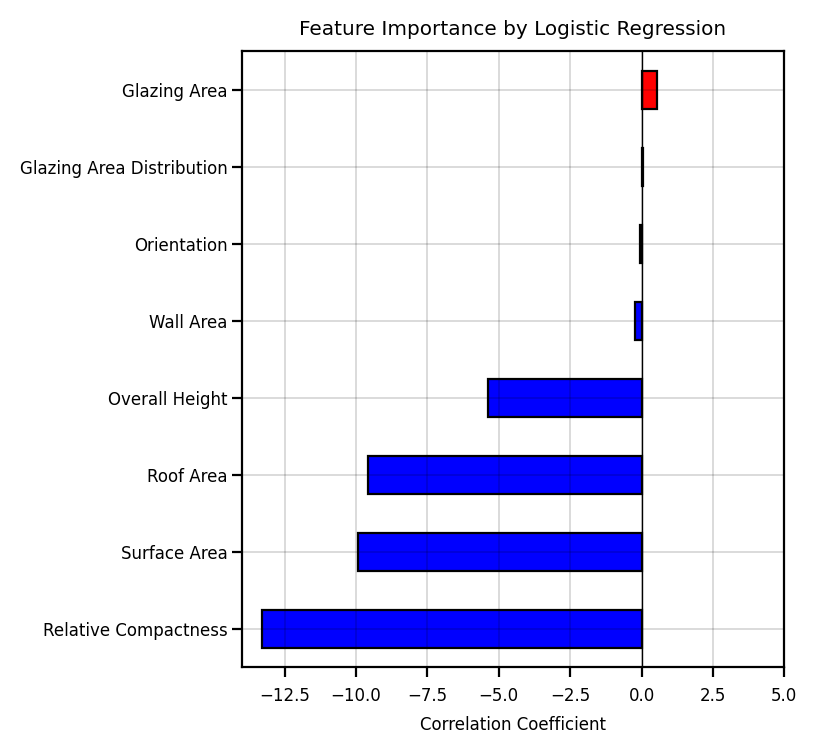

In [11]:
font = {'size'   : 6}
plt.rc('font', **font)
fig, ax1 = plt.subplots(figsize=(3.5, 4), dpi= 200, facecolor='w', edgecolor='k')

Correlation_plot.corr_bar(result.params.values,clmns=features_colums,select=False,yfontsize=6.0,xlim = [-14, 5],
                          title=f'Feature Importance by Logistic Regression',ymax_vert_lin=30)


Figure below show p-values and confidence interval for logistic regression coefficients to predict target.

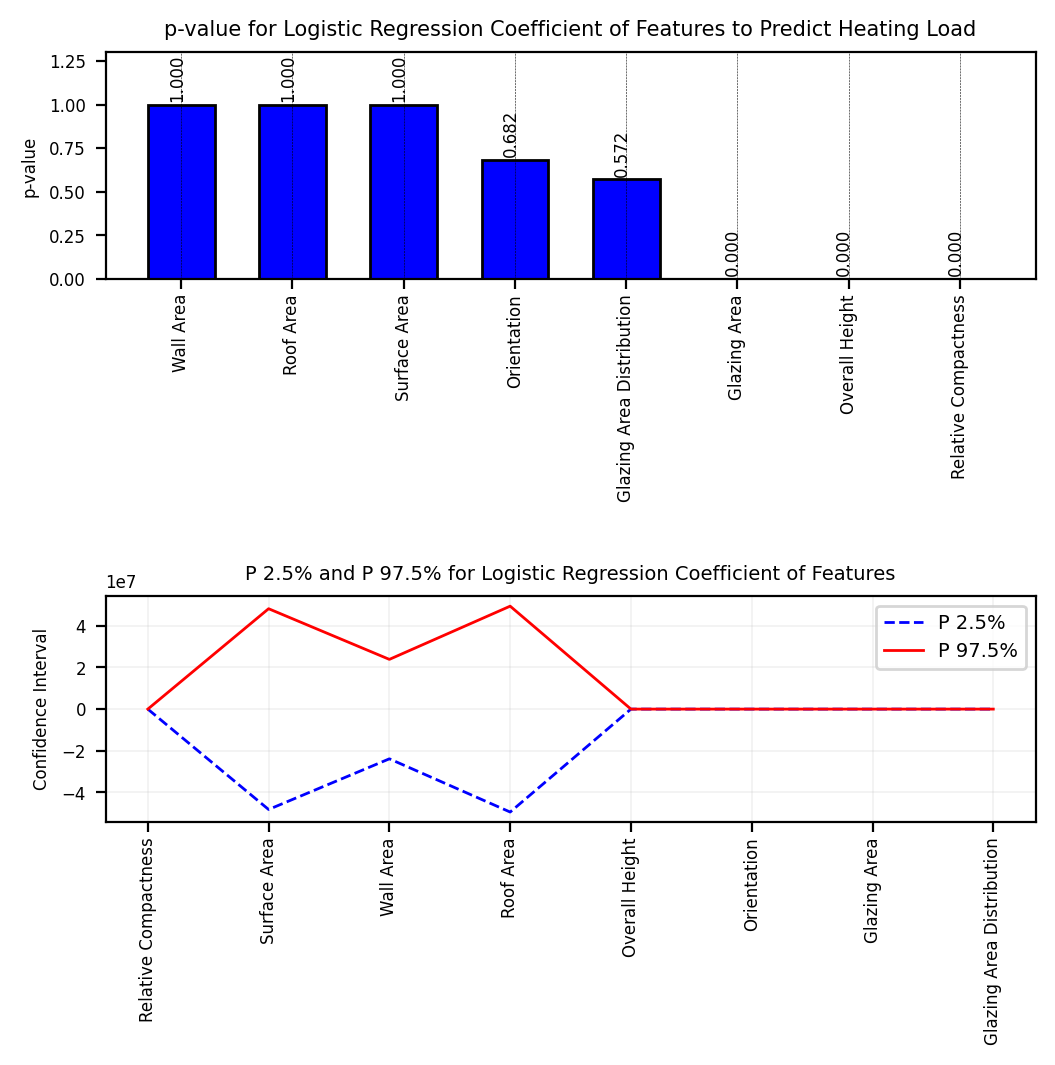

In [12]:
con_int=result.conf_int()
con_int.columns=['p2.5','p97.5']

font = {'size'   :6 }
plt.rc('font', **font)
fig=plt.figure(figsize=(6, 5), dpi= 200, facecolor='w', edgecolor='k')

ax1=plt.subplot(2,1,1) 

_=prfrmnce_plot(np.array(result.pvalues), 
                title=f'p-value for Logistic Regression Coefficient of Features to Predict Heating Load', 
                ylabel='p-value',
                clmns=features_colums,titlefontsize=7.5, 
                xfontsize=6, yfontsize=6).bargraph(fontsizelable=6.,
                xshift=-0.12,axt=ax1,yshift=0.04,ylim=[0,1.3],y_rot=90)

ax2=plt.subplot(2,1,2) 
plt.plot(np.array(features_colums),np.array(con_int['p2.5']),'b--',label='P 2.5%',lw=1)  
plt.plot(np.array(features_colums),np.array(con_int['p97.5']), 'r',label='P 97.5%',lw=1)  

plt.title('P 2.5% and P 97.5% for Logistic Regression Coefficient of Features',fontsize=7)
plt.ylabel('Confidence Interval',fontsize=6)
plt.legend(loc=1,fontsize=7,markerscale=1.1)
ax2.grid(axis='both',linewidth='0.1')
ax2.set_xticklabels(features_colums, rotation=90,fontsize=6,y=0.02)
plt.subplots_adjust(wspace=0.9)
plt.subplots_adjust(hspace=1.4)

plt.show()

The coefficient of features with high p-values such as Surface Area, Wall Area, Roof Area, have multicolinearity and probably should be excluded from data set. However, more investigation should be done before removing features.

## Lasso Logistic Regression

Lasso or L1 Regularization is a regularization technique of Linear Regression that can be used for feature selection. We investigate removing multicollinearity by Lasso. It adds a regularization term to the cost function a term $\large\alpha \sum_{i=1}^{n} \left| w_{i} \right| $. Since the cost function should be minimized, the higher α, the higher regularization. If α is high, then all weights will receive values close to zeros. If α=0, no regularization will be applied.

$\large MSE(w)+\alpha \sum_{i=1}^{n} \left| w_{i} \right|$

Lasso completely removes the weights for the features that are the least important (the values of the weights set to zero). So, feature selection can be automatically applied by Lasso Regularization. Figure below shows applying lasso for different α  values.

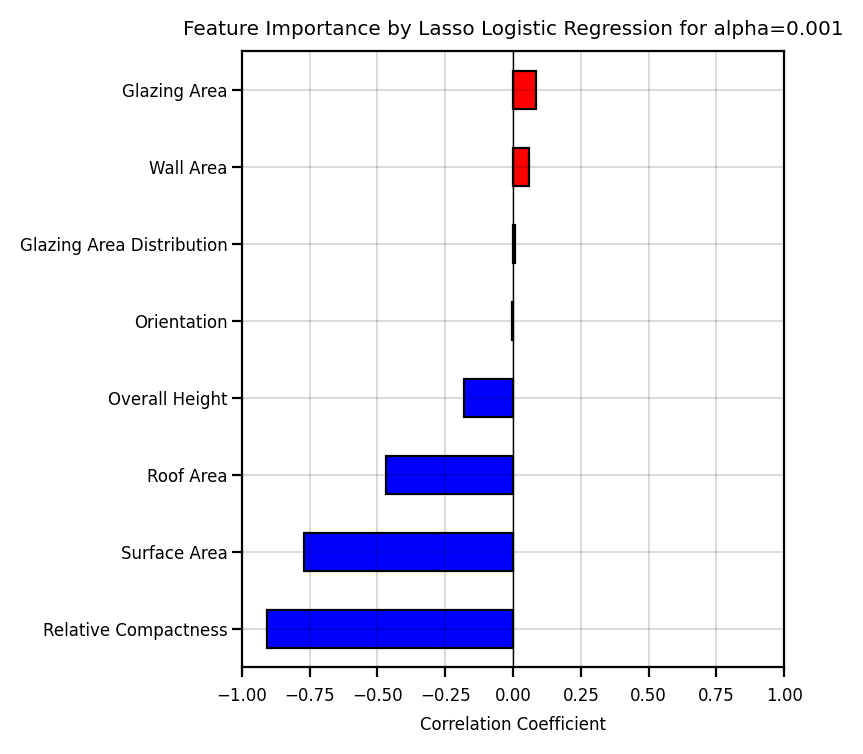

In [13]:
alpha=0.001
clf = linear_model.Lasso(alpha=alpha)
clf.fit(X_train_std, y_train)
font = {'size'   : 6}
plt.rc('font', **font)
fig, ax1 = plt.subplots(figsize=(3.5, 4), dpi= 200, facecolor='w', edgecolor='k')

Correlation_plot.corr_bar(clf.coef_,clmns=features_colums,select=False,yfontsize=6.0,xlim= [-1, 1],
                          title=f'Feature Importance by Lasso Logistic Regression for alpha={alpha}',ymax_vert_lin=30)

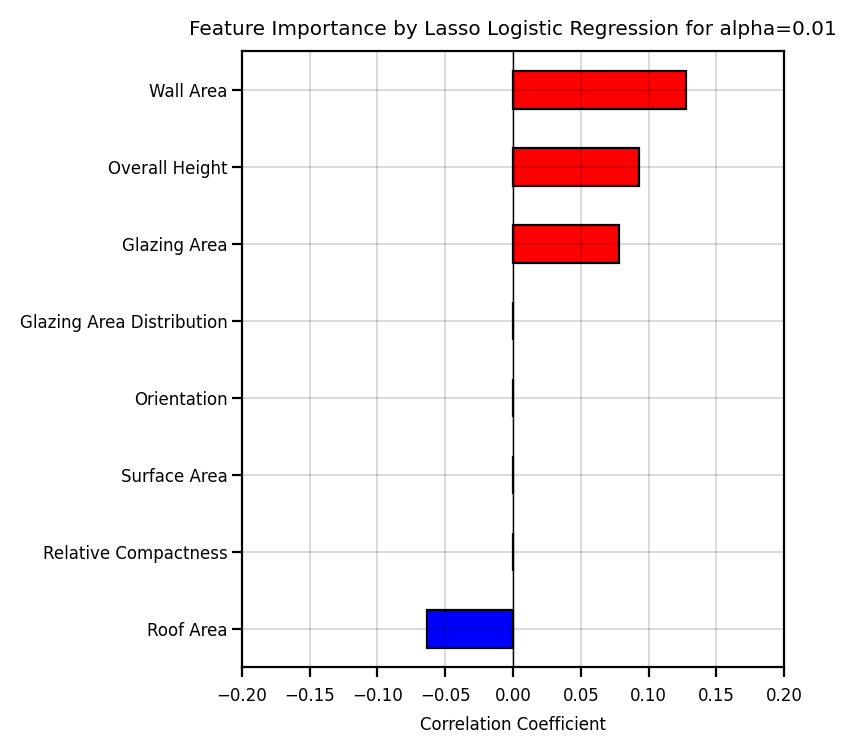

In [14]:
alpha=0.01
clf = linear_model.Lasso(alpha=alpha)
clf.fit(X_train_std, y_train)
font = {'size'   : 6}
plt.rc('font', **font)
fig, ax1 = plt.subplots(figsize=(3.5, 4), dpi= 200, facecolor='w', edgecolor='k')

Correlation_plot.corr_bar(clf.coef_,clmns=features_colums,select=False,yfontsize=6.0,xlim= [-0.2, 0.2],
                          title=f'Feature Importance by Lasso Logistic Regression for alpha={alpha}',ymax_vert_lin=30)

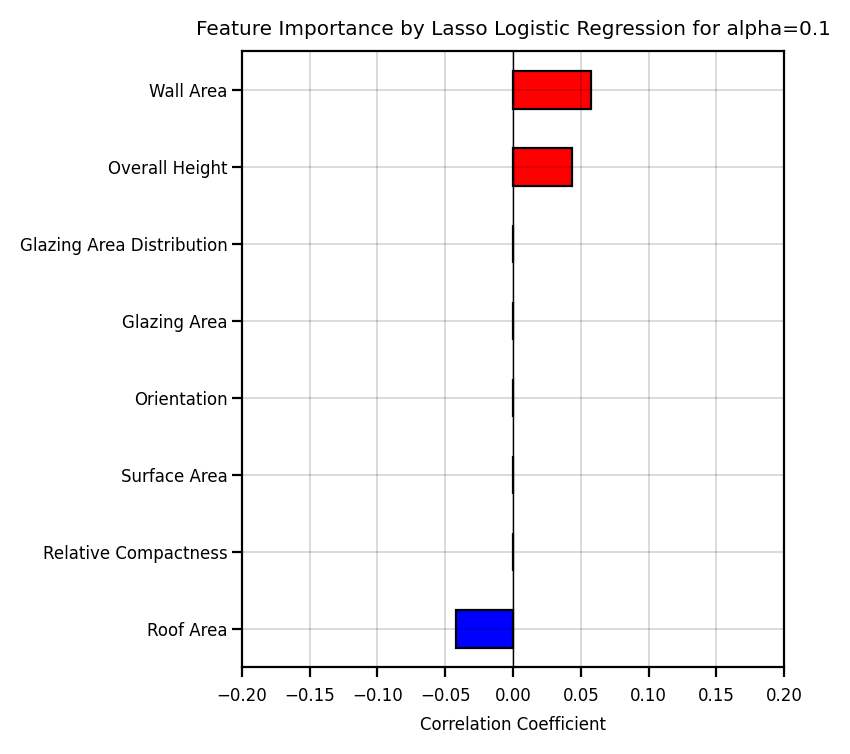

In [15]:
alpha=0.1
clf = linear_model.Lasso(alpha=alpha)
clf.fit(X_train_std, y_train)
font = {'size'   : 6}
plt.rc('font', **font)
fig, ax1 = plt.subplots(figsize=(3.5, 4), dpi= 200, facecolor='w', edgecolor='k')

Correlation_plot.corr_bar(clf.coef_,clmns=features_colums,select=False,yfontsize=6.0,xlim= [-0.2, 0.2],
                          title=f'Feature Importance by Lasso Logistic Regression for alpha={alpha}',ymax_vert_lin=30)

**As can be seen, Lasso cannot remove multicollinearity**

# Variance Inflation Factor

The best way to identify the multicollinearity is to calculate the `Variance Inflation Factor (VIF)` corresponding to every independent Variable in the Dataset. VIF tells us about how well an independent variable is predictable using the other independent variables. 

VIF is a number that determines whether a variable has multicollinearity or not. That number also represents how much a variable is inflated because of the linear dependence with other variables. The example below shows how VIF works. If we have 5 independent variables, To calculate the VIF of variable Var 1, this variable is isolated and consider as the target variable and all the other variables will be treated as the predictor variables to train a regression model and calculate the corresponding $R^{2}$ and $VIF$. This process is repeated all independent variables.
 
<br> 

<div>
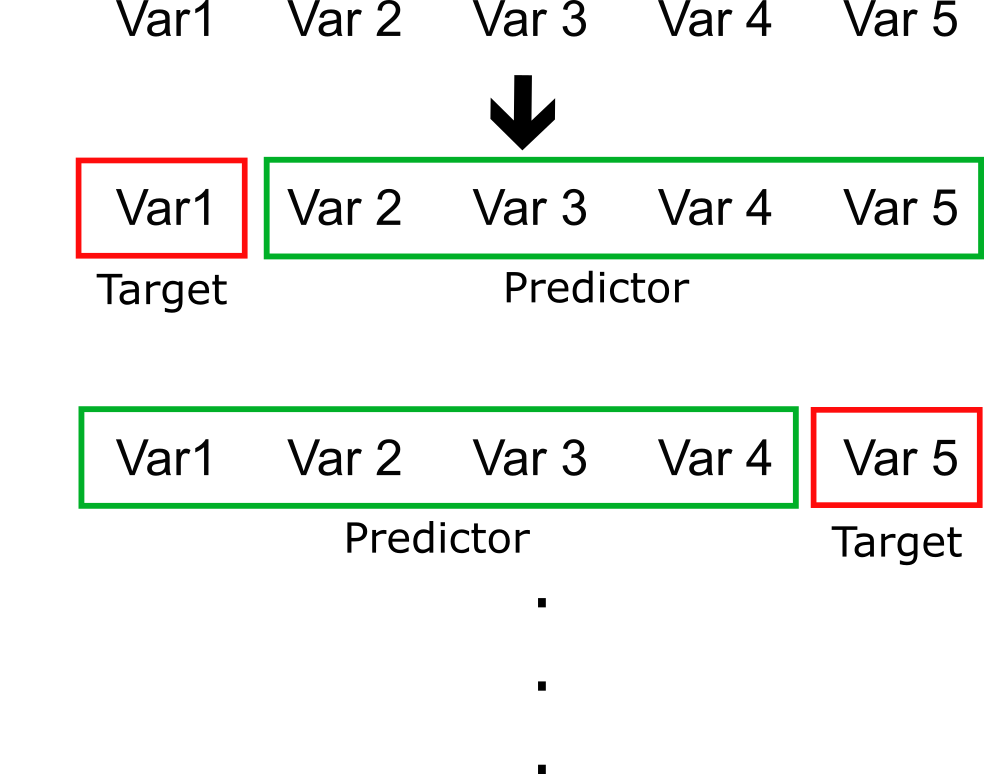
</div>
<br> 
<br> 

$\LARGE R^{2}=1-\frac{MSE(model)}{MSE(baseline)} \,\,\,\,\, \Rightarrow \,\,\,\,\, VIF=\frac{1}{1-R^{2}}$
<br> 

The VIF value starts from 1, and it has no upper limit. It is suggested to keep features having VIF<5. However, we should not remove all features that have VIF<5. We should first remove features with very high VIF, then calculate VIF again. This process should be repeated until reasonable VIF is calculated. See [Medium](https://medium.com/analytics-vidhya/what-is-multicollinearity-and-how-to-remove-it-413c419de2f) and [Correlation and Collinearity](https://blog.clairvoyantsoft.com/correlation-and-collinearity-how-they-can-make-or-break-a-model-9135fbe6936a) for more information. 

In [16]:
vif_feature=df.drop('Binary Classes', axis=1)

In [17]:
%%time
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(vif_feature.values, i) for i in range(vif_feature.values.shape[1])]
vif_info['Column'] = vif_feature.columns
vif_info.sort_values('VIF', ascending=False)

Wall time: 9 ms


,VIF,Column
1,inf,Surface Area
2,inf,Wall Area
3,inf,Roof Area
0,105.524054,Relative Compactness
4,31.205474,Overall Height
6,1.047508,Glazing Area
7,1.047508,Glazing Area Distribution
5,1.000000,Orientation


In [18]:
vif_info[vif_info.VIF>150].sort_values('VIF', ascending=False)

,VIF,Column
1,inf,Surface Area
2,inf,Wall Area
3,inf,Roof Area


Top three features with infinity VIF are *Surface Area*, *Wall Area*, *Roof Area*. We can remove these features and calculate VIF again:

In [19]:
%%time
# Calculte VIF after removing three features with very high VIF
colmns=list(vif_info[vif_info.VIF>150].sort_values('VIF', ascending=False)['Column'])
vif_feature_new=vif_feature.drop(colmns,axis=1)
vif_info_new = pd.DataFrame()
vif_info_new['VIF'] = [variance_inflation_factor(vif_feature_new, i) for i in range(vif_feature_new.shape[1])]
vif_info_new['Column'] = vif_feature_new.columns
vif_info_new.sort_values('VIF', ascending=False)

Wall time: 6.54 ms


,VIF,Column
0,3.176273,Relative Compactness
1,3.176273,Overall Height
3,1.047508,Glazing Area
4,1.047508,Glazing Area Distribution
2,1.000000,Orientation


Removing top three features with infinity VIF leads to remove multicollinearity. It must be noted that we should NOT remove all features with high VIF, feature should be removed sequentially as explained above.

# Synthetic Example 1

In [20]:
import scipy.linalg
from scipy.stats import norm
import scipy.stats

# Make a synthetic correlation matric for 4 propeties
corr=np.zeros((4,4))
corr[0,0]=corr[1,1]=corr[2,2]=corr[3,3]=1.0
#
corr[0,1]=corr[1,0]=0.75
corr[0,2]=corr[2,0]=-0.4
corr[0,3]=corr[3,0]=0.75
#
corr[1,2]=corr[2,1]=0.12
corr[1,3]=corr[3,1]=0.40
#
corr[2,3]=corr[3,2]=-0.54

# Make synthetic data for simulation 
nsim=10000 # number of simulation
val=[]
mu=5; sigma=1
# Normal distribution
val.append(np.random.normal(mu, sigma, nsim))
# Lognormal distribution
val.append(np.random.lognormal(0.58, 0.5, nsim))
# Triangular distribution
val.append(np.random.triangular(0,2.5, 5, nsim))
# Triangular distribution
val.append(np.random.triangular(0,0.5, 5, nsim))

# Order the random distributions of variable to respect the correlation between them
np.random.seed(42)
matrix=corr
L=scipy.linalg.cholesky(matrix, lower=True, overwrite_a=True)
mu=0; sigma=1; nvar=len(matrix)
w=np.zeros((nvar,nsim)) 

for i in range (nvar):
    for j in range(nsim):
        Dist = np.random.normal(mu, sigma, nsim)
        w[i,:]=Dist

Sim_R_val=[]
N_var=[]
for i in range(nsim):
    tmp=(np.matmul(L,w[:,i]))
    N_var.append(tmp)       
N_var=np.array(N_var).transpose()   
#
Sim_R_val=[]
for i1 in range(nvar):
    R_tmp=np.zeros(len(val[i1]))
    tmp=np.sort(N_var[i1])
    tmp_1=np.sort(val[i1])
    for i2 in range(nsim):
        index1=np.where(N_var[i1]==tmp[i2])[0]
        index2=np.where(val[i1]==tmp_1[i2])[0] 
        R_tmp[index1[0]]=val[i1][index2[0]]
    Sim_R_val.append(R_tmp)  
#    
columns=['Feature ' +str(i+1) for i in range(3)]+['Target']
df=pd.DataFrame({columns[0]:np.array(Sim_R_val[0]),columns[1]:np.array(Sim_R_val[1]),
                  columns[2]:np.array(Sim_R_val[2]),columns[3]:np.array(Sim_R_val[3])},columns=columns)    

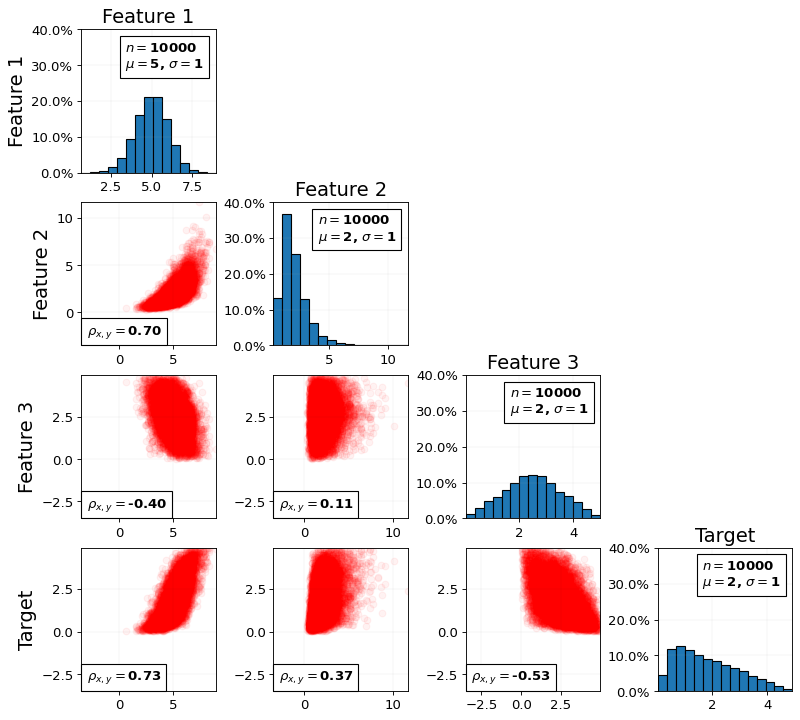

In [21]:
font = {'size'   :14 }
plt.rc('font', **font)

fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')
# Make cross plot matrix
cplotmatrix(df,alpha=0.05,marker='ro',missin_rep=False, font=font)

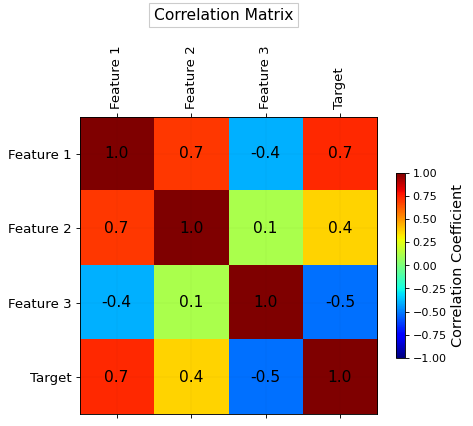

In [22]:
# Correlation matrix
font = {'size'   : 13}
plt.rc('font', **font)
fig, ax=plt.subplots(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')

corr_array=Correlation_plot.corr_mat(df,
        title=f'Correlation Matrix',corr_val_font=14,
        titlefontsize=14,xy_title=[0.5,-1.8],xyfontsize = 12,vlim=[-1, 1],axt=ax)

In [23]:
target='Target'
scaler = StandardScaler()
features_colums=df.drop([target],axis=1).columns
X_train_std=scaler.fit_transform(df[features_colums])
y_train=df[target]

In [24]:
logit_model=sm.OLS(y_train,X_train_std)
result=logit_model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                 Target   R-squared (uncentered):                   0.165
Model:                            OLS   Adj. R-squared (uncentered):              0.165
Method:                 Least Squares   F-statistic:                              660.5
Date:                Fri, 23 Dec 2022   Prob (F-statistic):                        0.00
Time:                        09:10:57   Log-Likelihood:                         -20856.
No. Observations:               10000   AIC:                                  4.172e+04
Df Residuals:                    9997   BIC:                                  4.174e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

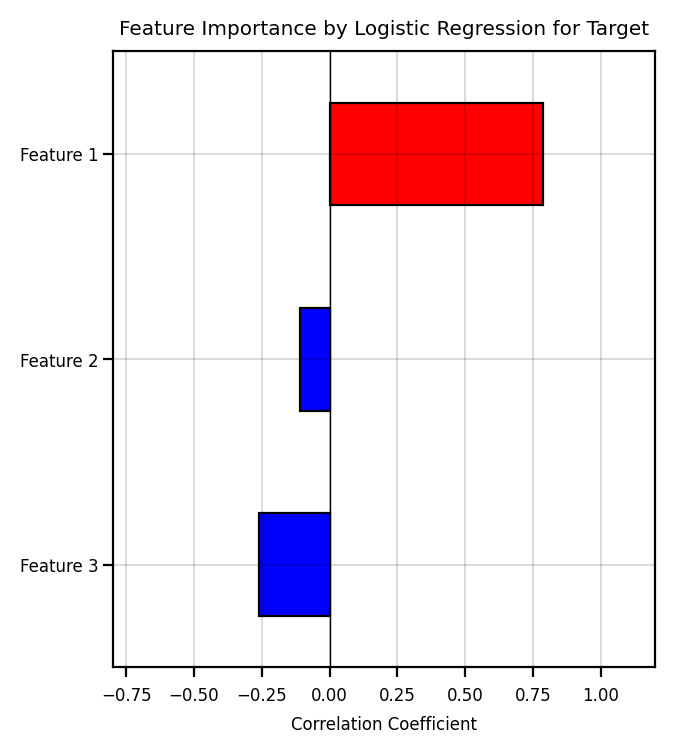

In [25]:
font = {'size'   : 6}
plt.rc('font', **font)
fig, ax1 = plt.subplots(figsize=(3.5, 4), dpi= 200, facecolor='w', edgecolor='k')

Correlation_plot.corr_bar(result.params.values,clmns=features_colums,select=False,yfontsize=6.0,xlim = [-0.8, 1.2],
                          title=f'Feature Importance by Logistic Regression for Target',ymax_vert_lin=30)


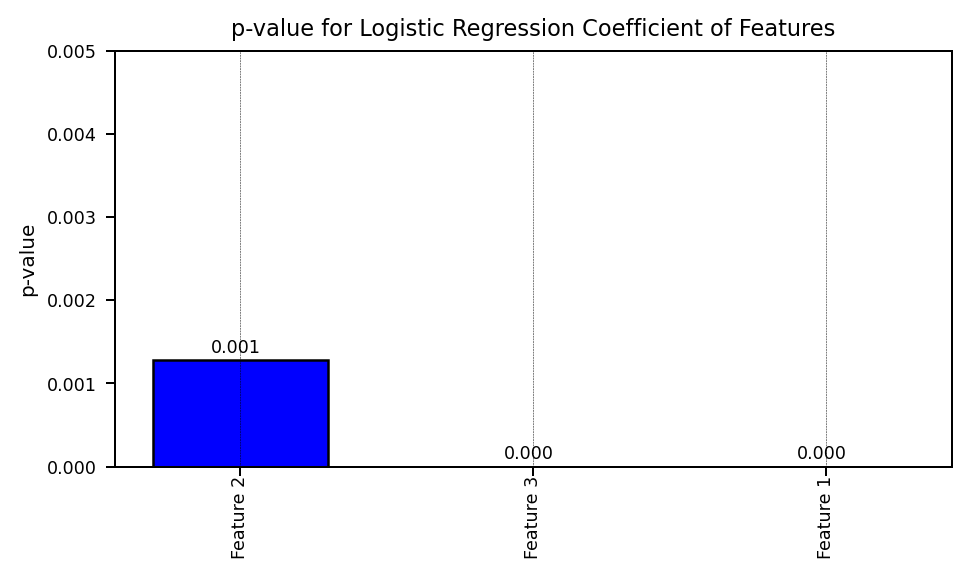

In [26]:
# Plot the importance of features
font = {'size'   : 7}
plt.rc('font', **font)
fig, ax1 = plt.subplots(figsize=(6, 3), dpi= 180, facecolor='w', edgecolor='k')

_=prfrmnce_plot(np.array(result.pvalues), title='p-value for Logistic Regression Coefficient of Features', 
            ylabel='p-value',
              clmns=features_colums,titlefontsize=9, 
              xfontsize=7, yfontsize=8).bargraph(fontsizelable=7,axt=ax1,
              xshift=-0.1,yshift=0.00009,ylim=[0,0.005],y_rot=0)

Feature 2 is positively correlated with Target but logistic regression gives negative coefficient. This is happening because of multicollinearity.

Variance inflation factor proves this:

In [27]:
vif_feature=df.drop([target],axis=1)
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(vif_feature, i) for i in range(3)]
vif_info['Column'] = vif_feature.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
0,9.749203,Feature 1
1,7.492443,Feature 2
2,4.384104,Feature 3


# Synthetic Example 2

Synthetic example below shows the correlation between 4 features and target.

In [28]:
# Make a synthetic correlation matric for 4 propeties
corr=np.zeros((4,4))
corr[0,0]=corr[1,1]=corr[2,2]=corr[3,3]=1.0
#
corr=np.zeros((5,5))
corr[0,0]=corr[1,1]=corr[2,2]=corr[3,3]=corr[4,4]=1.0


corr[0,1]=corr[1,0]=0.05
corr[0,2]=corr[2,0]=0.043
corr[0,3]=corr[3,0]=0.071
corr[0,4]=corr[4,0]=0.36
#
corr[1,2]=corr[2,1]=0.69
corr[1,3]=corr[3,1]=0.34
corr[1,4]=corr[4,1]=-0.42
#
corr[2,3]=corr[3,2]=0.74
corr[2,4]=corr[4,2]=-0.64
#
corr[3,4]=corr[4,3]=-0.77

# Make synthetic data for simulation 
nsim=10000 # number of simulation
val=[]
mu=5; sigma=1
val.append(np.random.normal(mu, sigma, nsim))
mu=90; sigma=16
val.append(np.random.normal(mu, sigma, nsim))
mu=60; sigma=10
val.append(np.random.normal(mu, sigma, nsim))
mu=30; sigma=4
val.append(np.random.normal(mu, sigma, nsim))
mu=10; sigma=2
val.append(np.random.normal(mu, sigma, nsim))

# Order the random distributions of variable to respect the correlation between them
np.random.seed(42)
matrix=corr
L=scipy.linalg.cholesky(matrix, lower=True, overwrite_a=True)
mu=0; sigma=1; nvar=len(matrix)
w=np.zeros((nvar,nsim)) 

for i in range (nvar):
    for j in range(nsim):
        Dist = np.random.normal(mu, sigma, nsim)
        w[i,:]=Dist

Sim_R_val=[]
N_var=[]
for i in range(nsim):
    tmp=(np.matmul(L,w[:,i]))
    N_var.append(tmp)       
N_var=np.array(N_var).transpose()   
#
Sim_R_val=[]
for i1 in range(nvar):
    R_tmp=np.zeros(len(val[i1]))
    tmp=np.sort(N_var[i1])
    tmp_1=np.sort(val[i1])
    for i2 in range(nsim):
        index1=np.where(N_var[i1]==tmp[i2])[0]
        index2=np.where(val[i1]==tmp_1[i2])[0] 
        R_tmp[index1[0]]=val[i1][index2[0]]
    Sim_R_val.append(R_tmp)  
#    
columns=['Feature ' +str(i+1) for i in range(4)]+['Target']
df=pd.DataFrame({columns[0]:np.array(Sim_R_val[0]),columns[1]:np.array(Sim_R_val[1]),
                 columns[2]:np.array(Sim_R_val[2]),columns[3]:np.array(Sim_R_val[3]),
                 columns[4]:np.array(Sim_R_val[4])},columns=columns)    

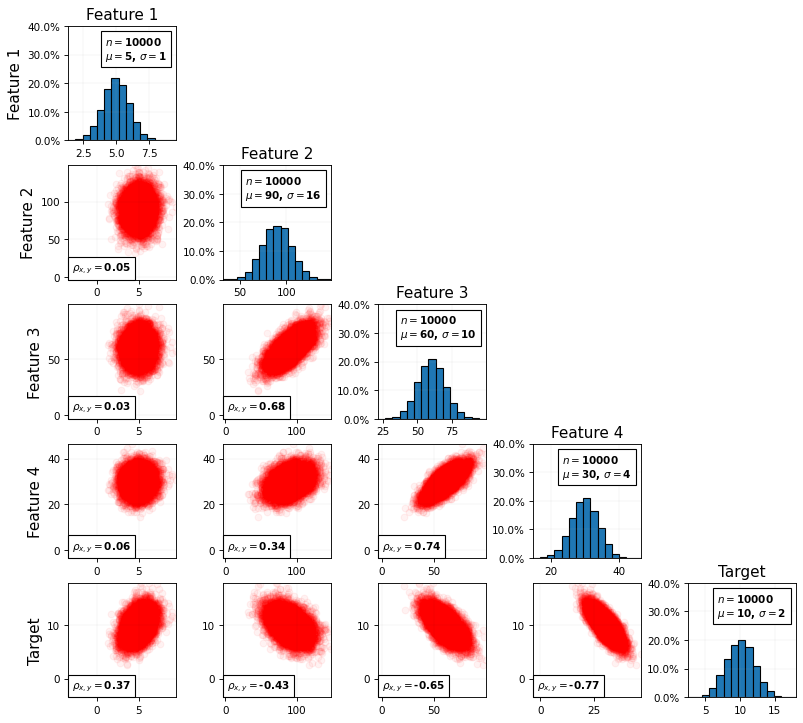

In [29]:
font = {'size'   :11 }
plt.rc('font', **font)

fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')
# Make cross plot matrix
cplotmatrix(df,alpha=0.05,marker='ro',missin_rep=False,font=font)

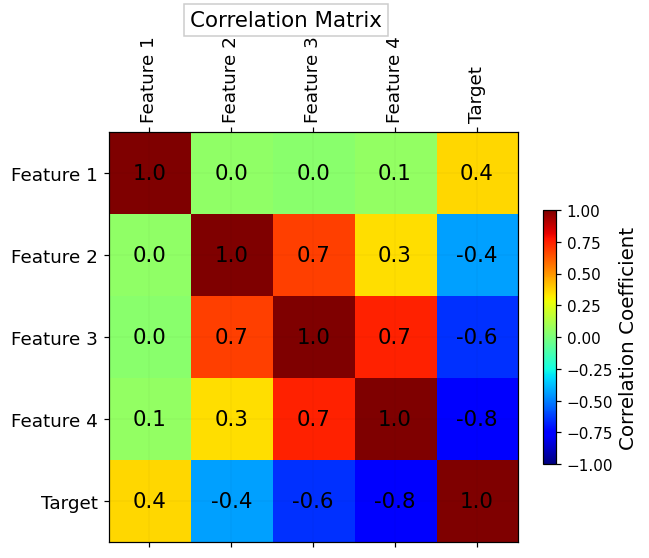

In [30]:
# Correlation matrix
font = {'size'   : 13}
plt.rc('font', **font)
fig, ax=plt.subplots(figsize=(6, 6), dpi= 110, facecolor='w', edgecolor='k')

corr_array=Correlation_plot.corr_mat(df,
        title=f'Correlation Matrix',corr_val_font=14,
        titlefontsize=14,xy_title=[0.5,-1.8],xyfontsize = 12,vlim=[-1, 1],axt=ax)

In [31]:
target='Target'
scaler = StandardScaler()
features_colums=df.drop([target],axis=1).columns
X_train_std=scaler.fit_transform(df[features_colums])
y_train=df[target]

In [32]:
logit_model=sm.OLS(y_train,X_train_std)
result=logit_model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                 Target   R-squared (uncentered):                   0.030
Model:                            OLS   Adj. R-squared (uncentered):              0.030
Method:                 Least Squares   F-statistic:                              78.61
Date:                Fri, 23 Dec 2022   Prob (F-statistic):                    9.15e-66
Time:                        09:11:12   Log-Likelihood:                         -37304.
No. Observations:               10000   AIC:                                  7.462e+04
Df Residuals:                    9996   BIC:                                  7.465e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

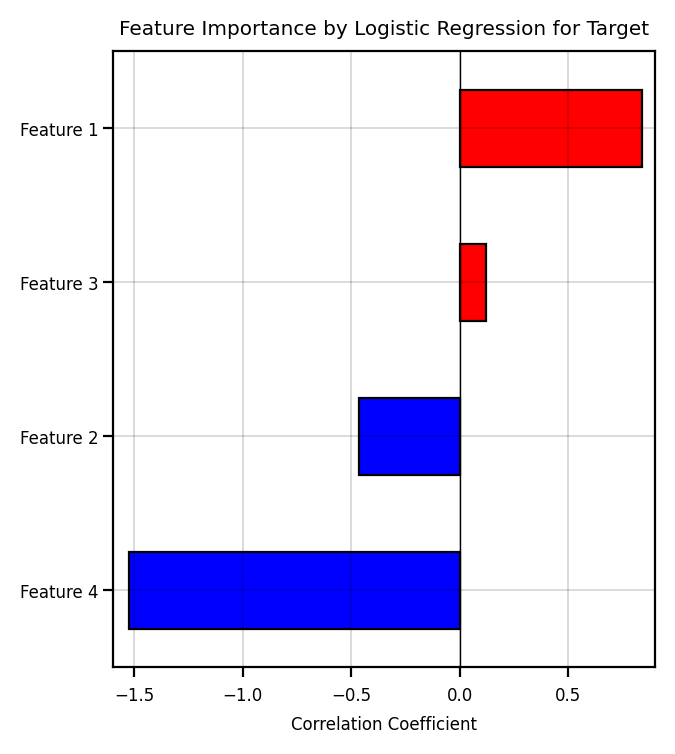

In [33]:
font = {'size'   : 6}
plt.rc('font', **font)
fig, ax1 = plt.subplots(figsize=(3.5, 4), dpi= 200, facecolor='w', edgecolor='k')

Correlation_plot.corr_bar(result.params.values,clmns=features_colums,select=False,yfontsize=6.0,xlim = [-1.6, 0.9],
                          title=f'Feature Importance by Logistic Regression for Target',ymax_vert_lin=30)

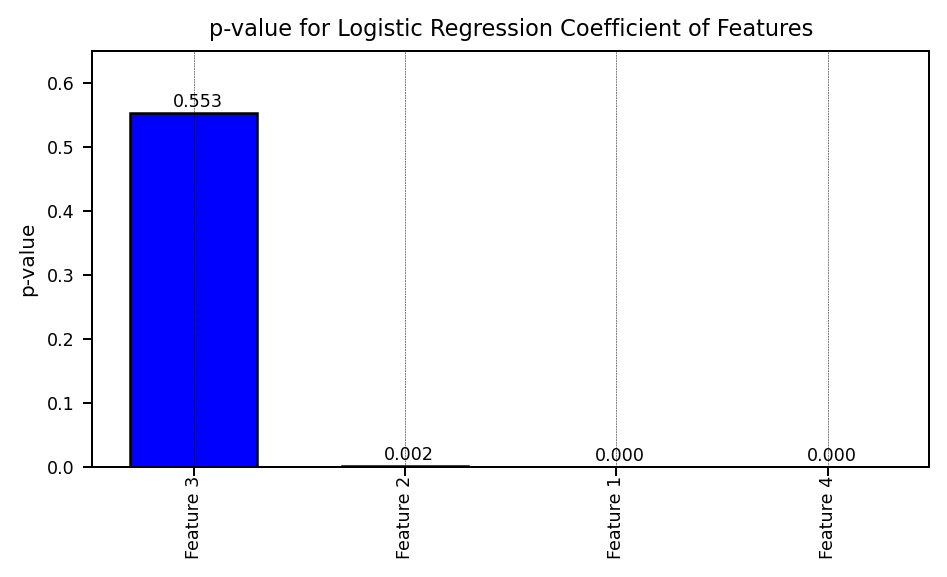

In [34]:
# Plot the importance of features
font = {'size'   : 7}
plt.rc('font', **font)
fig, ax1 = plt.subplots(figsize=(6, 3), dpi= 180, facecolor='w', edgecolor='k')

_=prfrmnce_plot(np.array(result.pvalues), title='p-value for Logistic Regression Coefficient of Features', 
            ylabel='p-value',
              clmns=features_colums,titlefontsize=9, 
              xfontsize=7, yfontsize=8).bargraph(fontsizelable=7,axt=ax1,
                                        xshift=-0.1,yshift=0.009,ylim=[0,0.65],y_rot=0)

Feature 3 is negatively correlated with Target but logistic regression gives negative coefficient. This is happening because of multicollinearity. Moreover, Feature 3 gives high p-value which makes it insignificant. This is no problem for prediction but it misleads interpretation.

Variance inflation factor proves this:

In [35]:
vif_feature=df.drop([target],axis=1)
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(vif_feature, i) for i in range(4)]
vif_info['Column'] = vif_feature.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
2,154.823536,Feature 3
3,102.560651,Feature 4
1,61.078690,Feature 2
0,20.420751,Feature 1
